# Stock Factor Decomposition

We analyze the factor decomposition of various stocks in the context of the Capital Asset Pricing Model (CAPM), the Fama–French Three-Factor Model (FF3), and the Fama–French Five-Factor Model (FF5). Our goal is to identify which factors within these models exert the strongest influence on different categories of stocks. We also examine the time evolution of these decompositions for selected stocks and relate their fluctuations to underlying economic and political events. In addition, we track the annualized `alpha` together with the corresponding `t`- and `p`-values in order to assess the statistical significance of potential arbitrage opportunities.

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'src')))
import analysis

import warnings
warnings.simplefilter("ignore", category = FutureWarning)

## Fixed-interval analysis

We will perform FF5 regressions on stocks from four distinct industries: technology, healthcare, finance, and energy. For each industry, we select three companies that best capture the typical behavior of its stocks. Tech will be represented by `GOOGL`, `MSFT`, and `AAPL`; healthcare by `JNJ`, `PFE`, and `ABBV`; finance by `V`, `MA`, and `PYPL`; and energy by `CVX`, `XOM`, and `SHEL`. The analysis covers the period of relative market stability from 2016 to 2019.

Each of the stocks is regressed onto the five factors of the FF5 model:

- **Market Risk Premium (MKT_RF)**  
   - Definition: The return of the market portfolio minus the risk-free rate.  
   - Interpretation: Captures the compensation investors require for taking on market risk. A higher loading means the stock is more sensitive to overall market movements.

- **Small Minus Big (SMB)**  
   - Definition: The return spread between small-cap stocks and large-cap stocks.  
   - Interpretation: Measures the tendency of smaller firms to outperform larger firms over the long run. A positive loading means the stock behaves more like smaller companies; a negative loading means it behaves more like larger companies.

- **High Minus Low (HML)**  
   - Definition: The return spread between value stocks (high book-to-market ratios) and growth stocks (low book-to-market ratios).  
   - Interpretation: Captures whether the stock behaves like a value firm (positive loading) or a growth firm (negative loading).

- **Robust Minus Weak (RMW)**  
   - Definition: The return spread between firms with robust (high) operating profitability and those with weak (low) profitability.  
   - Interpretation: Indicates whether the stock aligns more with highly profitable firms (positive loading) or weakly profitable firms (negative loading).

- **Conservative Minus Aggressive (CMA)**  
   - Definition: The return spread between firms that invest conservatively (low asset growth) and those that invest aggressively (high asset growth).  
   - Interpretation: Reflects whether the stock behaves more like firms with restrained, disciplined investment (positive loading) or firms that expand aggressively (negative loading).

Alongside the decompositions, we also compute the R² scores of the regressions, which represent the proportion of a stock’s variance explained by the model.

In [2]:
start, end = '2016-01-01', '2020-01-01'
factors = analysis.get_factors("FF5", start, end)
returns = analysis.get_returns(['GOOGL', 'MSFT', 'AAPL', 'JNJ', 'PFE', 'ABBV', 'V', 'MA', 'PYPL', 'CVX', 'XOM', 'SHEL'], start, end)
coeffs, tstats, pstats, r2 = analysis.factor_regression(returns, factors, precision = 5)

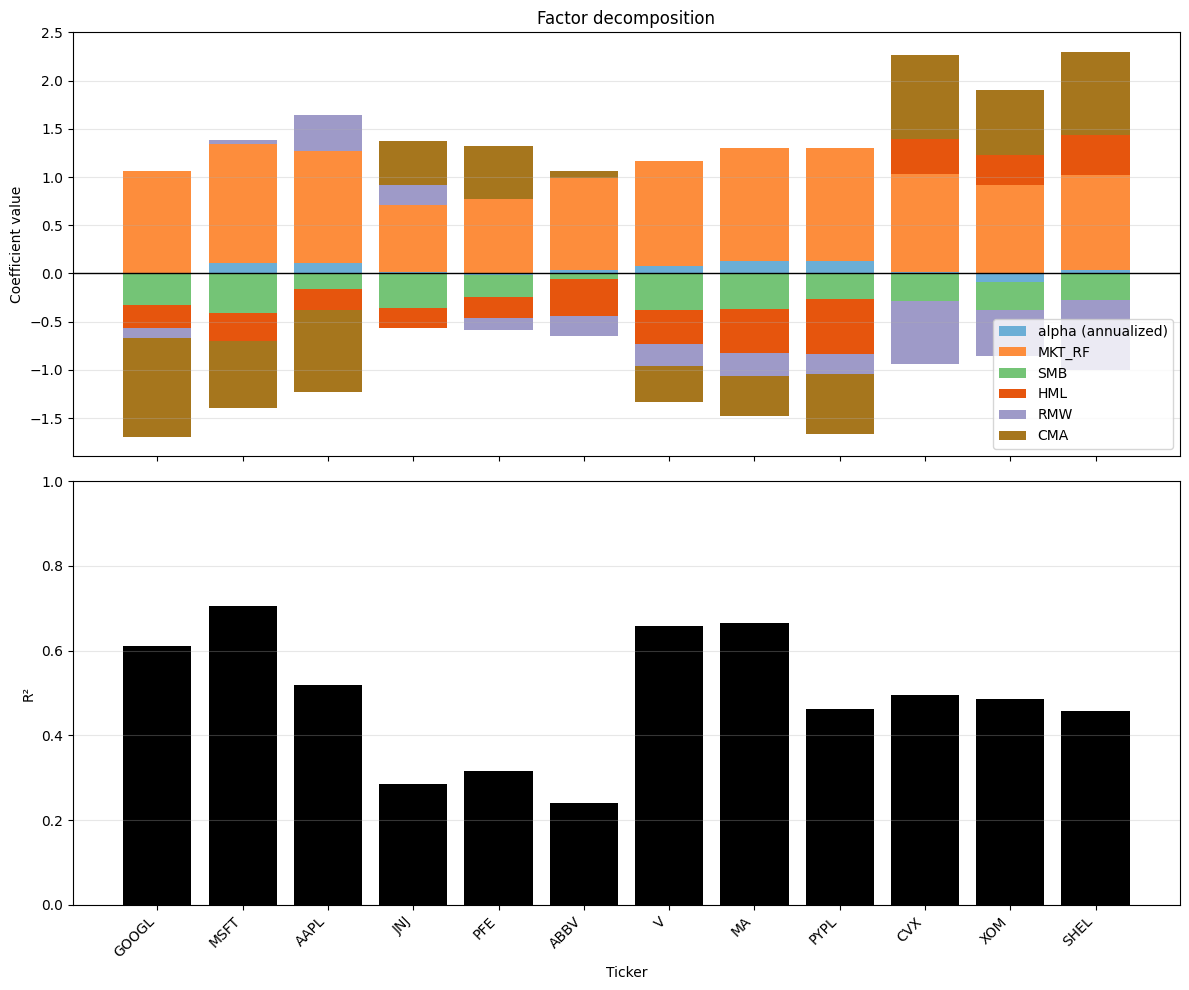

In [3]:
analysis.plot_coeffs(coeffs, r2)

All four categories of stocks exhibit distinct behaviors:

- **Tech:**
These are characterized by relatively high R² scores, which means that a significant proportion of risks associated with these stocks are systematic ones tied to market fluctuations. The beta coefficient (associated with overall market fluctuations `MKT_RF`) is consistently above 1, meaning that these stocks react more strongly than the market as a whole. The negative `SMB` values reflect the fact that the selected firms are very large companies, while the negative `HML` values highlight their “growth” profile — they are priced for future earnings rather than current book value. `CMA` is very strongly negative. This is because tech firms reinvest heavily in R&D and expansion, which corresponds to “aggressive” investment in the FF5 model. The `RMW` factor doesn’t have a definite sign, indicating inconsistent profitability of these companies.

- **Healthcare:**
Unlike tech, healthcare stocks tend to have much lower R² scores. This means that most of the risks associated with these assets are company-specific (e.g. trial results, patent approvals) and can be diversified away. The beta coefficient is typically lower than 1, indicating the defensive nature of these stocks — they move less than the market overall. The `SMB` factor is negative, reflecting the dominance of large, established healthcare companies, and the `HML` factor is often slightly negative to neutral, since these firms are valued partly for their growth potential. However, the `CMA` is positive, due to their more conservative investment patterns: healthcare companies generally expand steadily rather than aggressively. The `RMW` factor is usually positive, as many large pharmaceutical and healthcare firms generate robust and consistent operating profitability.

- **Finance:**
Finance stocks behave in many ways like tech, with relatively high R² and betas around or slightly above 1, but they diverge in two important respects. First, `RMW` is more consistently negative. Second, while `CMA` remains negative, its values are much closer to zero, reflecting more conservative and regulated investment compared to the aggressive reinvestment typical of tech.

- **Energy:**
Energy stocks have below-average R² scores, with betas close to 1, meaning they move broadly in line with the market. Their `HML` loadings are positive, reflecting value characteristics of asset-heavy firms trading at lower valuations. `RMW` is negative, consistent with profitability that is cyclical and weaker when scaled to equity. `CMA` is positive, as large energy companies generally invest conservatively, expanding cautiously and returning significant cash to shareholders.

All the examples considered above are well-known large firms, leading to consistently negative `SMB` scores.

Analysis with smaller models provides a simplified version of this picture. Under the CAPM, for instance, we find:

In [2]:
start, end = '2016-01-01', '2020-01-01'
factors = analysis.get_factors("CAPM", start, end)
returns = analysis.get_returns(['GOOGL', 'MSFT', 'AAPL', 'JNJ', 'PFE', 'ABBV', 'V', 'MA', 'PYPL', 'CVX', 'XOM', 'SHEL'], start, end)
coeffs, tstats, pstats, r2 = analysis.factor_regression(returns, factors, precision = 5)

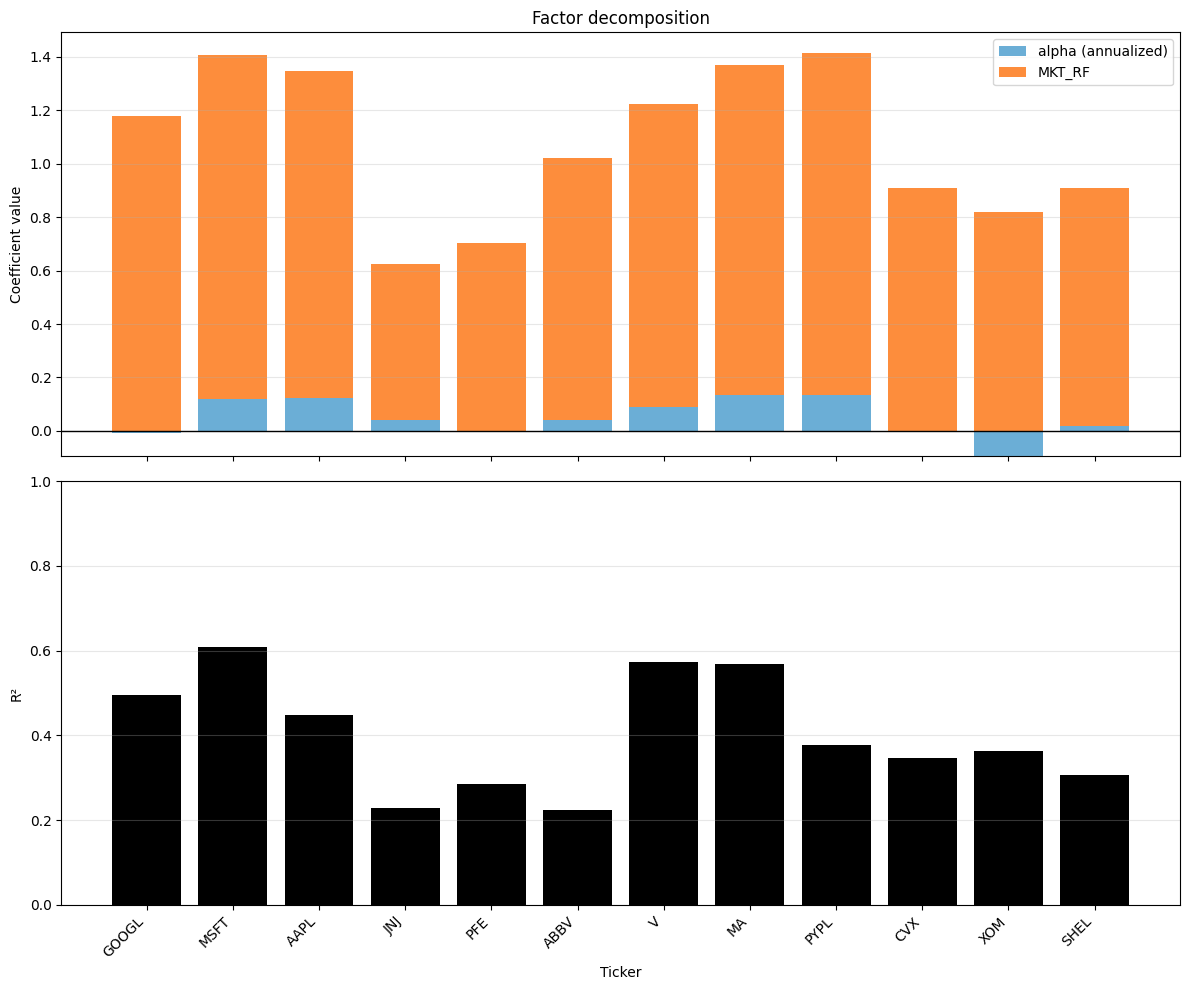

In [3]:
analysis.plot_coeffs(coeffs, r2)

Unsurprisingly, the R² scores are significantly lower across the board. More importantly, the annualized alpha values are much larger than those produced by the richer models. These alphas are false signals, reflecting well-understood risks that are misattributed to the intercept in an overly simplistic framework. Indeed, even some of the alpha signals flagged under the FF5 model can be reinterpreted as exposures to more advanced factors, such as momentum.

## Rolling-window analysis

The primary motivation for performing factor decomposition is to detect periods of statistically significant non-zero alpha, which represent potential arbitrage opportunities. In the earlier examples, alpha was annualized, but even then it remained negligible compared to the factor loadings. To identify periods of statistically significant non-zero alpha, the analysis needs to be performed on a much finer timescale. We do this by applying a rolling window over the sample period and running independent regressions at each position of the window. Focusing on the 2016–2019 interval, we examine a stock that exhibited one of the more pronounced alpha signals during this time — `NFLX` — and use a rolling window of 35 days.

In [16]:
start, end = '2016-01-01', '2020-01-01'
factors = analysis.get_factors('FF5', start, end)
returns = analysis.get_returns('NFLX', start, end)

coeffs, tstats, pstats, r2 = analysis.factor_regression(returns, factors, precision = 5, window = 35)

Performing the rolling factor decomposition reveals that annualized alpha can be comparable in magnitude to other factor loadings, once it is no longer averaged out over the full four-year period.

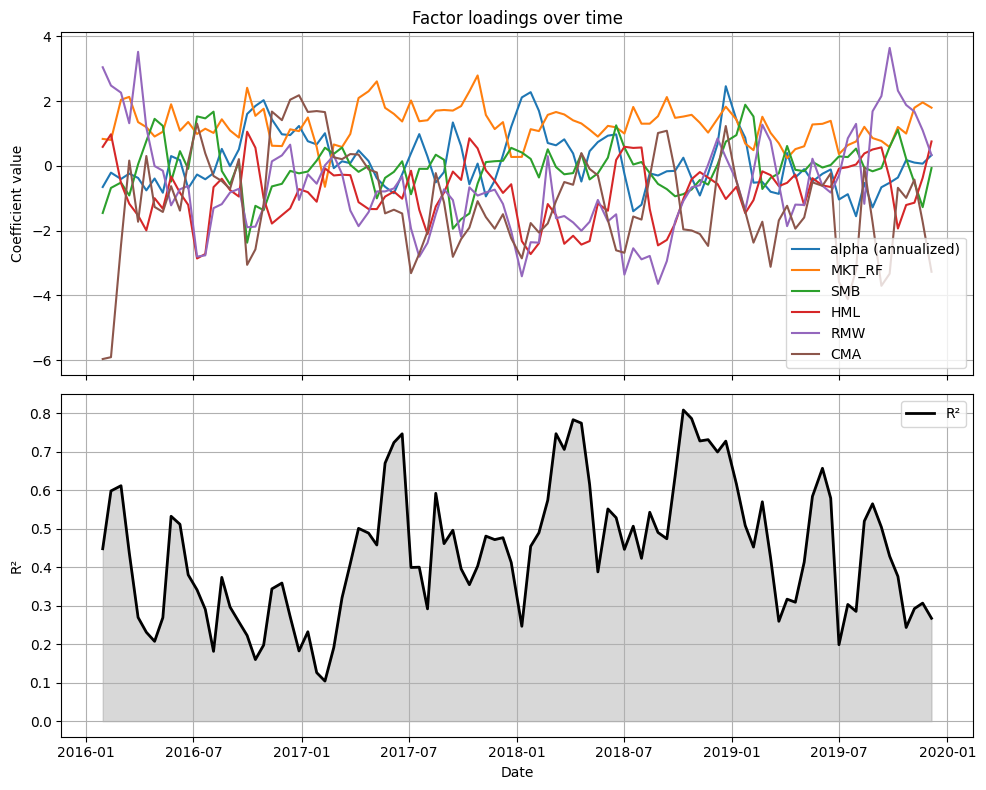

In [17]:
analysis.plot_coeffs(coeffs, r2)

However, simply identifying periods of non-zero alpha is not sufficient, as these may merely reflect statistical noise. A genuine signal should also be accompanied by a sufficiently large t-value (with `∣t∣ > 2`) to be considered statistically significant. Below, we plot the annualized alpha alongside its corresponding t-statistic over the same period. The red-shaded regions indicate time periods where the t-value is sufficiently high to rule out random noise.

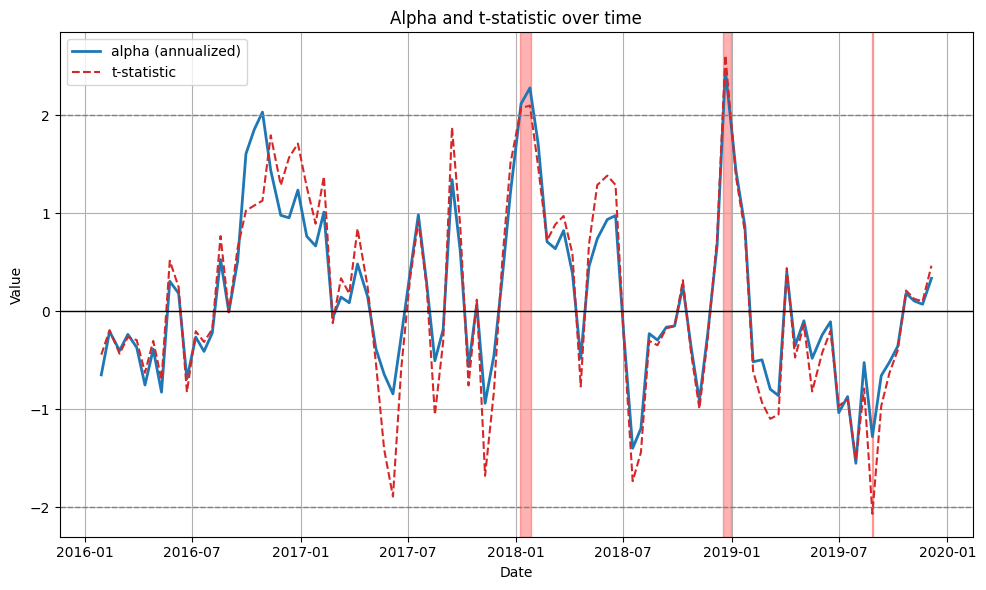

In [18]:
analysis.plot_alpha(coeffs, tstats)

Two such regions can be clearly identified: the beginning and the end of 2018. In hindsight, the origins of these events are relatively straightforward. The early-2018 spike in alpha corresponds to Netflix’s strong earnings surprise in January, when subscriber growth far exceeded expectations. The late-2018 signal aligns with the combination of a broad market rebound after the December selloff and the release of Bird Box, which generated record-breaking viewership. Together, these episodes illustrate how rolling factor decomposition can capture short-lived bursts of statistically significant alpha driven by firm-specific catalysts.

In some cases, alpha does not arise from company-specific circumstances but instead emerges from broader global events. When this happens, it can appear across a large number of stocks simultaneously. One such event was the 2014–2016 collapse in oil prices, which heavily impacted the energy sector. To illustrate this, we focus on `XOM` as a representative example.

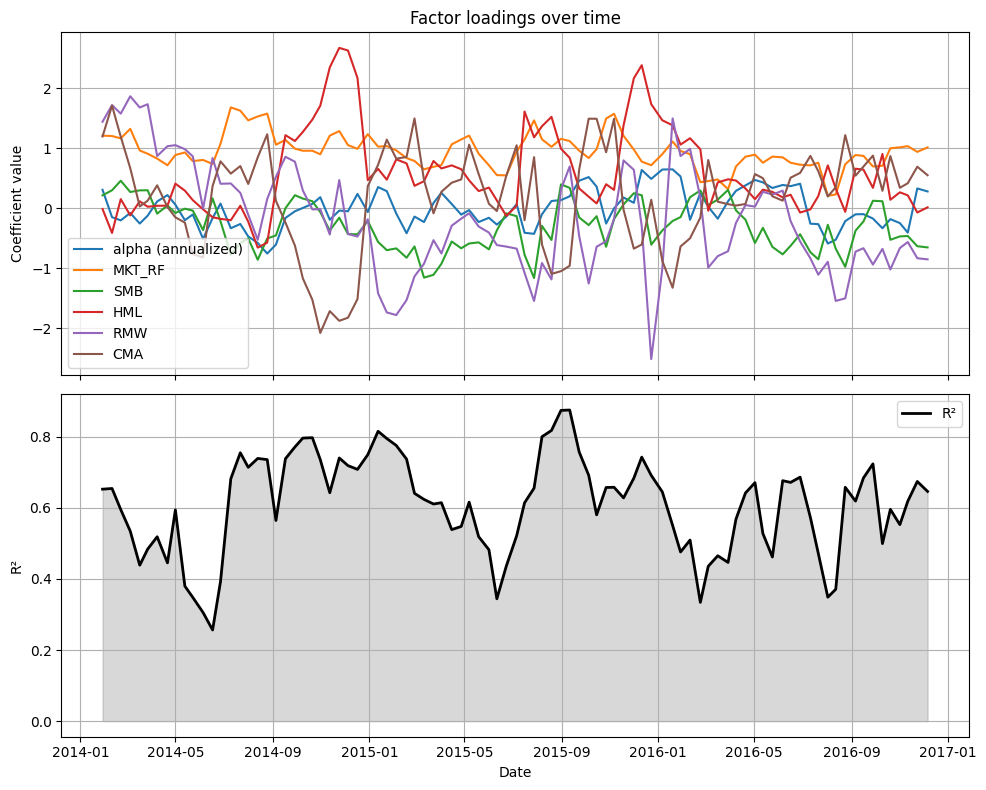

In [19]:
start, end = '2014-01-01', '2017-01-01'
factors = analysis.get_factors('FF5', start, end)
returns = analysis.get_returns('XOM', start, end)

coeffs, tstats, pstats, r2 = analysis.factor_regression(returns, factors, precision = 5, window = 35)

analysis.plot_coeffs(coeffs, r2)

While the factor decomposition itself does not show alpha reaching large magnitudes during this period, the t-statistic indicates that the negative dip around September 2014 is highly statistically significant. This episode is followed by a period of positive alpha in 2016, corresponding to the rebound in oil prices.

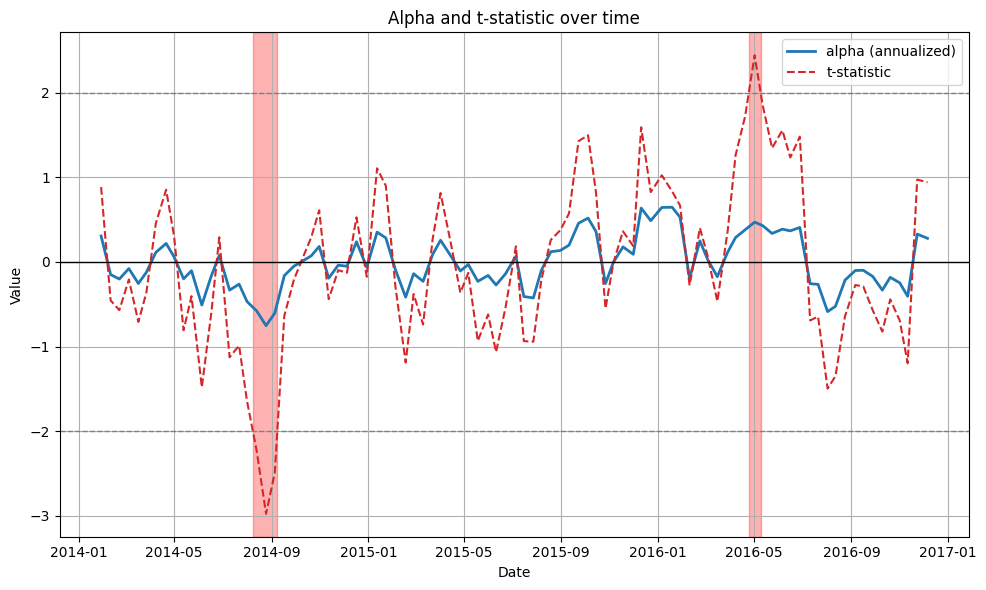

In [20]:
analysis.plot_alpha(coeffs, tstats)

Another example comes from the behavior of technology stocks, such as GOOGL, in the aftermath of the COVID-19 crash.

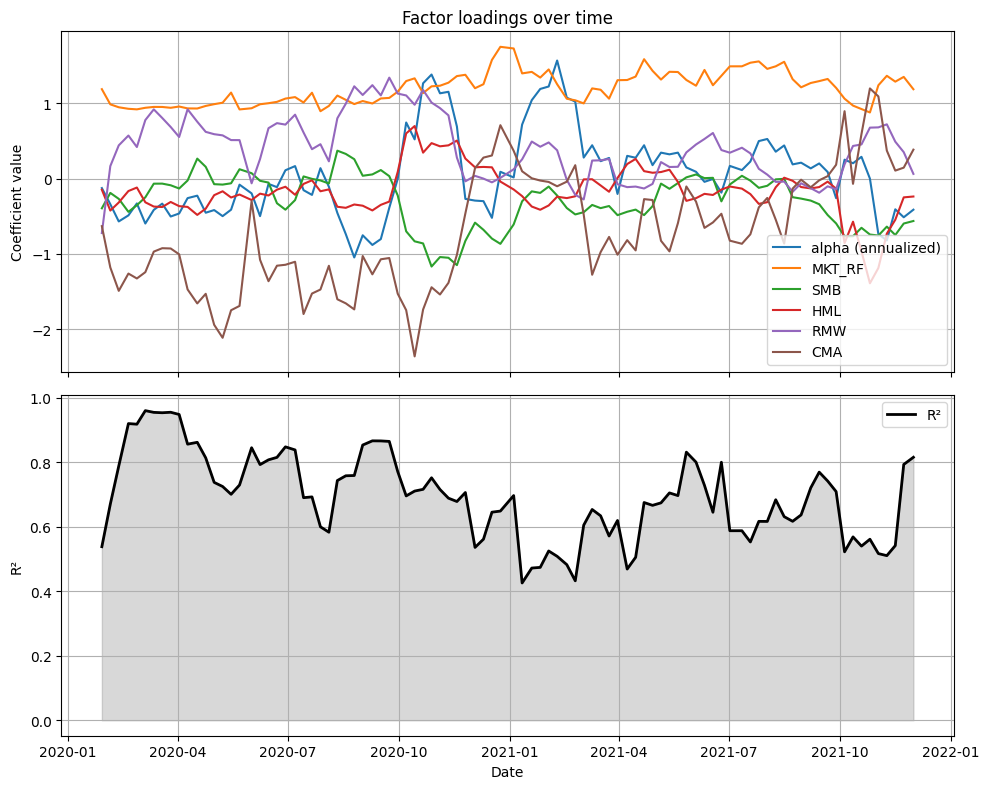

In [27]:
start, end = '2020-01-01', '2022-01-01'
factors = analysis.get_factors('FF5', start, end)
returns = analysis.get_returns('GOOGL', start, end)

coeffs, tstats, pstats, r2 = analysis.factor_regression(returns, factors, precision = 5, window = 35)

analysis.plot_coeffs(coeffs, r2)

The rolling factor decomposition reveals a sharp dip in alpha during September 2020, which corresponds to the broad market rotation out of high-growth technology stocks into more cyclical sectors as optimism about reopening grew. This negative alpha reflects the fact that tech underperformed relative to its factor exposures during that correction. By the end of October, however, the rebound in investor demand pushed alpha back into positive territory.

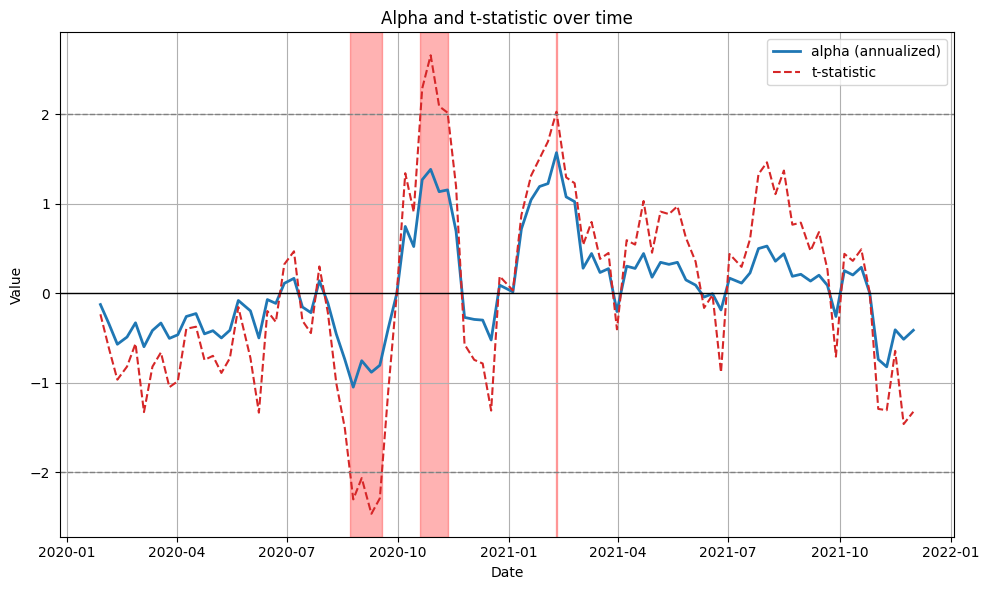

In [28]:
analysis.plot_alpha(coeffs, tstats)

The secondary spike in February 2021 is linked to a positive earnings report but does not reach strong statistical significance.

## Conclusions

This project applied factor decomposition to analyze stock returns across industries using both static and rolling-window regressions. The static analysis revealed systematic differences: tech stocks exhibited high betas and aggressive reinvestment, healthcare was defensive with low explanatory power, finance combined high betas with weak profitability, and energy showed value characteristics with conservative investment. Rolling analysis demonstrated that while alpha is negligible when averaged over long horizons, it can spike to magnitudes comparable to factor loadings over shorter windows, often around firm-specific events or global shocks. Importantly, only alphas accompanied by strong t-statistics can be considered genuine signals, underscoring the need to separate true opportunities from statistical noise.